## **Preparação do ambiente, importação dos dados e análise exploratória**


In [1]:
#Bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet#, LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Dados de coleta importados via csv de um repositório no github
#Link do repositório: https://github.com/eduardoscavalcanti/TCC_inteligencia_artificial_trocador_de_calor
raw_data =     'https://raw.githubusercontent.com/eduardoscavalcanti/TCC_inteligencia_artificial_trocador_de_calor/main/dados_treino_completo.csv'#16800


df = pd.read_csv(raw_data)
df


,Data,T1,T2,T3,T4,F1,F2,Amostra
0,26/10/2022 16:44:43321600,37.0636,28.2552,25.8884,25.0832,12.614795,0.0,acq500
1,26/10/2022 16:44:44335600,37.1368,28.2308,26.0348,25.0832,7.986195,0.0,acq500
2,26/10/2022 16:44:45334000,37.0880,28.0600,25.9616,25.1564,10.763355,0.0,acq500
3,26/10/2022 16:44:46394800,37.1124,27.9380,25.8396,25.1076,11.689075,0.0,acq500
4,26/10/2022 16:44:47330800,36.9660,27.9380,25.8884,25.1076,12.614795,0.0,acq500
...,...,...,...,...,...,...,...,...
16794,26/09/2022 21:16:20761000,39.5524,28.7188,30.1096,19.8860,241.267635,852.0,4200v0
16795,26/09/2022 21:16:21759400,39.5768,28.7920,30.1096,19.8616,241.267635,848.0,4200v0
16796,26/09/2022 21:16:22757800,39.5768,28.7188,30.1096,19.8616,242.193355,850.0,4200v0
16797,26/09/2022 21:16:23756200,39.5524,28.7432,30.1096,19.8860,241.267635,852.0,4200v0


In [2]:
#Remoção de vazoes quente e fria menores que 50 L/h 
df.drop(df[df.F1 < 50].index, inplace=True)
df.drop(df[df.F2 < 50].index, inplace=True)

df.sort_values(by=['F1'],inplace = True)
#Reset index
df.reset_index(inplace = True)

In [3]:


df_train = df[df.F2 <= 900]
df_test = df[df.F2 > 900]

#Colunas renomeadas para maior clareza
df_train.rename(columns={'T1': 'T1 - Entrada Quente', 
                   'T2': 'T2 - Saída Quente', 
                   'T3': 'T3 - Saída Fria',
                   'T4': 'T4 - Entrada Fria',
                   'F1': 'F1 - Vazão Quente',
                   'F2': 'F2 - Vazão Fria'
}, inplace=True)

#Colunas renomeadas para maior clareza
df_test.rename(columns={'T1': 'T1 - Entrada Quente', 
                   'T2': 'T2 - Saída Quente', 
                   'T3': 'T3 - Saída Fria',
                   'T4': 'T4 - Entrada Fria',
                   'F1': 'F1 - Vazão Quente',
                   'F2': 'F2 - Vazão Fria'
}, inplace=True)




/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


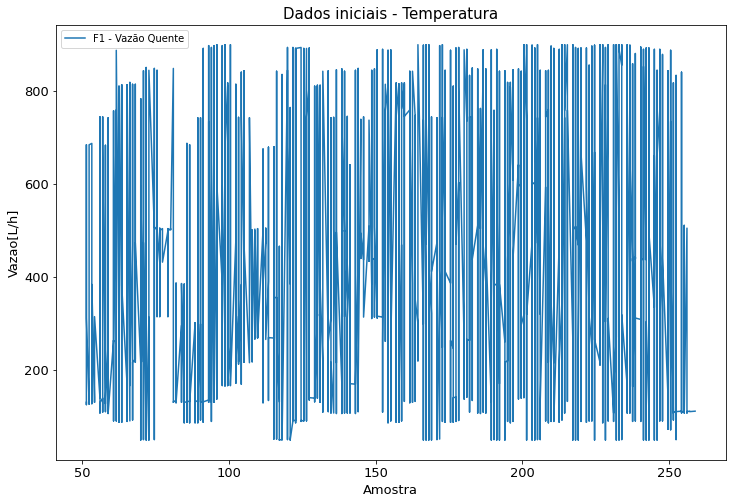

In [4]:
#Plot das vazoes
plt.figure(figsize=(12,8))
plt.plot(df_train['F1 - Vazão Quente'], df_train['F2 - Vazão Fria'])
plt.title('Dados iniciais - Temperatura',fontsize=15)
plt.legend(['F1 - Vazão Quente', 'F2 - Vazão Fria'],loc=0)
plt.xlabel('Amostra',fontsize=13)
plt.ylabel('Vazao[L/h]',fontsize=13)
plt.tick_params(labelsize=13)
plt.show()

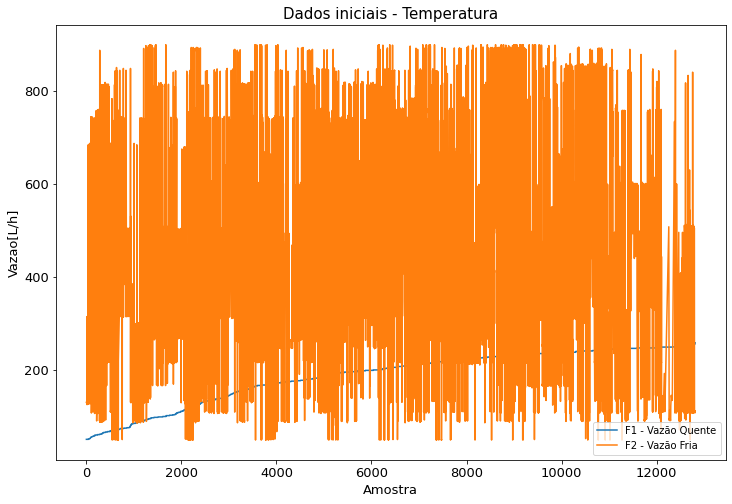

In [5]:
#Plot das vazoes
plt.figure(figsize=(12,8))
plt.plot(df_train.index, df_train['F1 - Vazão Quente'])
plt.plot(df_train.index, df_train['F2 - Vazão Fria'])
plt.title('Dados iniciais - Temperatura',fontsize=15)
plt.legend(['F1 - Vazão Quente', 'F2 - Vazão Fria'],loc=0)
plt.xlabel('Amostra',fontsize=13)
plt.ylabel('Vazao[L/h]',fontsize=13)
plt.tick_params(labelsize=13)
plt.show()

## **Preparação dos dados**

In [6]:
X_train = df_train[['T1 - Entrada Quente','T2 - Saída Quente','T3 - Saída Fria','T4 - Entrada Fria','F2 - Vazão Fria']]
X_test = df_test[['T1 - Entrada Quente','T2 - Saída Quente','T3 - Saída Fria','T4 - Entrada Fria','F2 - Vazão Fria']]
y_train = df_train['F1 - Vazão Quente']
y_test =df_test['F1 - Vazão Quente']

In [7]:
#Seed
SEED = 7
np.random.seed(SEED)

#Dados normalizados de -1 a 1 pela biblioteca StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [8]:
X_test

array([[-0.77598898, -2.42068384, -2.48065174,  0.0340418 ,  2.33075397],
       [-1.02430446, -2.53938742, -2.52160068, -0.10506197,  2.02493808],
       [-0.77598898, -2.38358897, -2.48065174,  0.0340418 ,  2.33494323],
       ...,
       [-0.56314714, -0.2543435 , -0.82904482,  2.76047566,  2.20926547],
       [-0.66956806, -0.52884553, -0.99284055,  2.12059833,  2.74130134],
       [ 0.30595704, -0.71431988, -1.1634611 ,  0.22878708,  3.09319908]])

## **Treino com parâmetros obtidos após Randomized Search CV**

In [9]:
#Foco em Mean Squared Error

lasso = Lasso(alpha=0)

enet = ElasticNet(alpha=0.0005)

krr = KernelRidge(alpha=0.1, coef0=0.1, gamma=1, kernel='rbf')

gbr = GradientBoostingRegressor(learning_rate=0.2, n_estimators=1500)

xgbr = xgb.XGBRegressor(gamma=0.1, learning_rate=0.5, n_estimators=2500, reg_alpha=1)

lgbr = lgb.LGBMRegressor(learning_rate=0.5, objective='regression')

rfr = RandomForestRegressor(max_features='log2', n_estimators=1000)

svr = SVR(C=100)

dtr = DecisionTreeRegressor(min_samples_split=8)

In [10]:
#Treinamento de modelos

predict_lasso = []
predict_krr = []
predict_enet = []
predict_svr = []
predict_dtr = []
predict_rfr = []
predict_gbr = []
predict_xgb = []
predict_lgb = []


predictions_list = [predict_lasso,predict_krr,predict_enet,predict_svr,predict_dtr,predict_rfr,predict_gbr,predict_xgb,predict_lgb]

models_list = [lasso,krr,enet,svr,dtr,rfr,gbr,xgbr,lgbr]

answers_predictions_list = []

for model in models_list:
    model.fit(X_train, y_train)
    
    answers_predictions_list.append(model.predict(X_test))

#Resultados de predicao de corrente quente armazenados em um dataframe df_predictions
df_predictions = {
    "lasso":  answers_predictions_list[0],
    "krr":    answers_predictions_list[1],
    "enet":   answers_predictions_list[2],
    "svr":    answers_predictions_list[3],
    "dtr":    answers_predictions_list[4],
    "rfr":    answers_predictions_list[5],
    "gbr":    answers_predictions_list[6],
    "xgb":    answers_predictions_list[7],
    "lgb":    answers_predictions_list[8],
    "y_test": y_test
}

df_predictions = pd.DataFrame(df_predictions)
df_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.245e+06, tolerance: 3.121e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, posi

[02:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,lasso,krr,enet,svr,dtr,rfr,gbr,xgb,lgb,y_test
0,133.875651,30.655600,133.903352,47.176343,141.752735,84.468256,44.644083,63.673073,66.172319,51.495035
2,121.879154,27.571148,121.914173,50.964583,59.085939,74.794482,55.338998,57.606449,46.971806,51.495035
3,135.883874,31.799589,135.910920,45.876736,141.752735,83.597153,45.139766,61.051136,66.172319,51.495035
18,149.147342,48.308811,149.164770,45.450304,152.552802,99.603778,38.293374,77.452347,66.957190,51.495035
19,142.582576,37.673516,142.604483,44.700233,69.855148,81.388385,42.386481,49.735649,61.092153,51.495035
...,...,...,...,...,...,...,...,...,...,...
12647,245.128102,36.919836,245.081309,220.764196,179.090108,173.526223,200.619800,216.275742,173.083688,251.450555
12648,244.652097,36.032534,244.605550,222.500067,179.090108,170.337117,185.286776,190.755356,169.969416,251.450555
12692,229.062126,201.151178,229.037084,210.856937,230.313282,229.560980,240.431928,246.031372,234.662005,252.376275
12703,246.709107,90.156549,246.653985,220.202064,197.758795,193.968897,214.198848,211.961639,211.669841,252.376275


In [11]:
#Calculo do MSE(Mean Square Error) e MAE (Mean Absolute Error) de cada modelo
mse_list = []
mae_list = []

for k in answers_predictions_list:
    mse_list.append(mean_squared_error(k,df_predictions["y_test"]))

for k in answers_predictions_list:
    mae_list.append(mean_absolute_error(k,df_predictions["y_test"]))


error_dictionary = {
  "lasso":  [mse_list[0],mae_list[0]],
  "krr":    [mse_list[1],mae_list[1]],
  "enet":   [mse_list[2],mae_list[2]],
  "svr":    [mse_list[3],mae_list[3]],
  "dtr":    [mse_list[4],mae_list[4]],
  "rfr":    [mse_list[5],mae_list[5]],
  "gbr":    [mse_list[6],mae_list[6]],
  "xgb":    [mse_list[7],mae_list[7]],
  "lgb":    [mse_list[8],mae_list[8]]
}


df_error = pd.DataFrame(error_dictionary,index = ['MSE', 'MAE'])
df_error

,lasso,krr,enet,svr,dtr,rfr,gbr,xgb,lgb
MSE,1699.462898,16667.076976,1698.388490,958.199621,3900.684640,2070.415859,2058.248608,2130.682107,1858.41490
MAE,31.784290,104.839770,31.765249,23.972067,50.242339,36.068297,36.202214,37.561095,34.08483


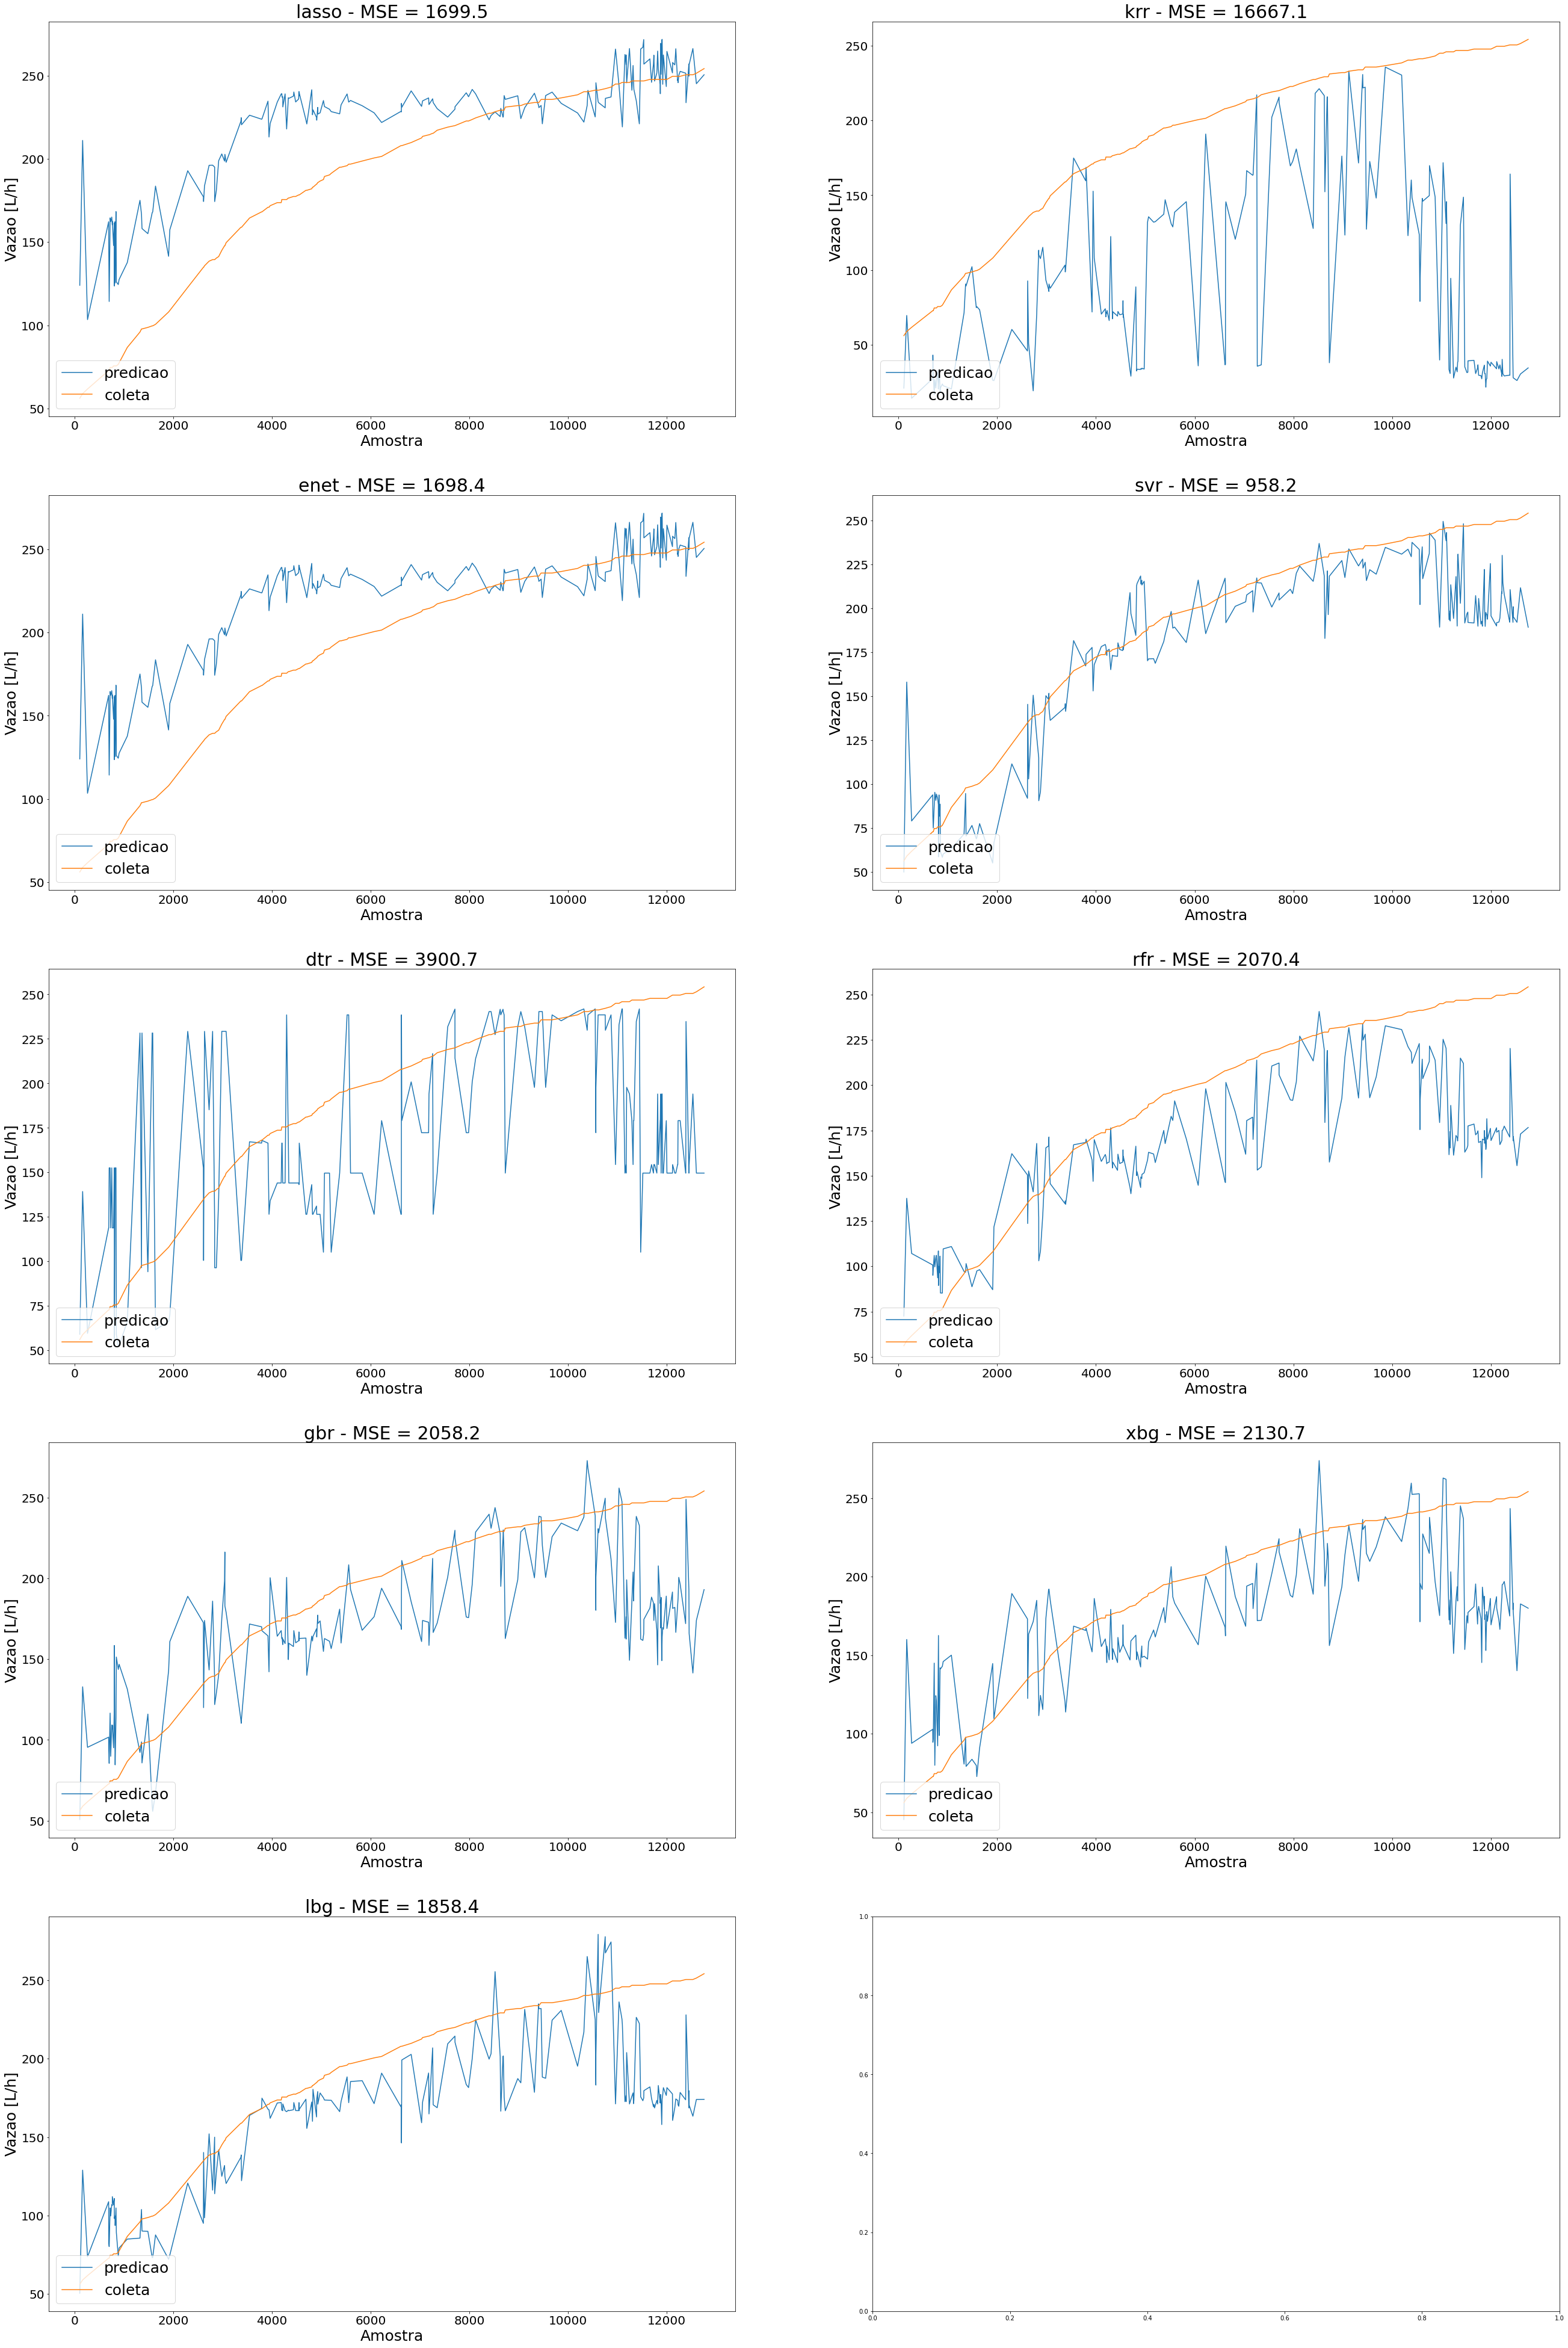

In [12]:
#Plot de pontos de coleta e predicao

#Redução para visualizar parte aleatoria das amostras
df_predictions_plot = df_predictions.sample(n = 200).sort_index()

X_plot =    df_predictions_plot .index 
Y0_coleta = df_predictions_plot ['y_test']
Y1_lasso =  df_predictions_plot ['lasso']
Y2_krr =    df_predictions_plot ['krr']
Y3_enet =   df_predictions_plot ['enet']
Y4_svr =    df_predictions_plot ['svr']
Y5_dtr =    df_predictions_plot ['dtr']
Y6_rfr =    df_predictions_plot ['rfr']
Y7_gbr =    df_predictions_plot ['gbr']
Y8_xgb =    df_predictions_plot ['xgb']
Y9_lgb =    df_predictions_plot ['lgb']




#Configuracoes de multiplas visualizacoes
figure, axis = plt.subplots(5, 2, figsize=(45,70))

#  lasso
axis[0, 0].plot(X_plot, Y1_lasso)
axis[0, 0].plot(X_plot, Y0_coleta)
axis[0, 0].set_title(f'lasso - MSE = {mse_list[0]:.1f}',fontsize=30)
axis[0, 0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[0, 0].set_xlabel('Amostra',fontsize=25)
axis[0, 0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[0, 0].tick_params(labelsize=20)

#  krr
axis[0, 1].plot(X_plot, Y2_krr)
axis[0, 1].plot(X_plot, Y0_coleta)
axis[0, 1].set_title(f'krr - MSE = {mse_list[1]:.1f}',fontsize=30)
axis[0, 1].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[0, 1].set_xlabel('Amostra',fontsize=25)
axis[0, 1].set_ylabel('Vazao [L/h]',fontsize=25)
axis[0, 1].tick_params(labelsize=20)

#  enet
axis[1,0].plot(X_plot, Y3_enet)
axis[1,0].plot(X_plot, Y0_coleta)
axis[1,0].set_title(f'enet - MSE = {mse_list[2]:.1f}',fontsize=30)
axis[1,0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[1,0].set_xlabel('Amostra',fontsize=25)
axis[1,0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[1,0].tick_params(labelsize=20)

#  svr
axis[1,1].plot(X_plot, Y4_svr)
axis[1,1].plot(X_plot, Y0_coleta)
axis[1,1].set_title(f'svr - MSE = {mse_list[3]:.1f}',fontsize=30)
axis[1,1].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[1,1].set_xlabel('Amostra',fontsize=25)
axis[1,1].set_ylabel('Vazao [L/h]',fontsize=25)
axis[1,1].tick_params(labelsize=20)

#  dtr
axis[2,0].plot(X_plot, Y5_dtr)
axis[2,0].plot(X_plot, Y0_coleta)
axis[2,0].set_title(f'dtr - MSE = {mse_list[4]:.1f}',fontsize=30)
axis[2,0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[2,0].set_xlabel('Amostra',fontsize=25)
axis[2,0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[2,0].tick_params(labelsize=20)

#  rfr
axis[2,1].plot(X_plot, Y6_rfr)
axis[2,1].plot(X_plot, Y0_coleta)
axis[2,1].set_title(f'rfr - MSE = {mse_list[5]:.1f}',fontsize=30)
axis[2,1].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[2,1].set_xlabel('Amostra',fontsize=25)
axis[2,1].set_ylabel('Vazao [L/h]',fontsize=25)
axis[2,1].tick_params(labelsize=20)

#  gbr
axis[3,0].plot(X_plot, Y7_gbr)
axis[3,0].plot(X_plot, Y0_coleta)
axis[3,0].set_title(f'gbr - MSE = {mse_list[6]:.1f}',fontsize=30)
axis[3,0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[3,0].set_xlabel('Amostra',fontsize=25)
axis[3,0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[3,0].tick_params(labelsize=20)

#  xgb
axis[3,1].plot(X_plot, Y8_xgb)
axis[3,1].plot(X_plot, Y0_coleta)
axis[3,1].set_title(f'xbg - MSE = {mse_list[7]:.1f}',fontsize=30)
axis[3,1].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[3,1].set_xlabel('Amostra',fontsize=25)
axis[3,1].set_ylabel('Vazao [L/h]',fontsize=25)
axis[3,1].tick_params(labelsize=20)

#  lgb
axis[4,0].plot(X_plot, Y9_lgb)
axis[4,0].plot(X_plot, Y0_coleta)
axis[4,0].set_title(f'lbg - MSE = {mse_list[8]:.1f}',fontsize=30)
axis[4,0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[4,0].set_xlabel('Amostra',fontsize=25)
axis[4,0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[4,0].tick_params(labelsize=20)


plt.show()

